<a href="https://colab.research.google.com/github/marcusmpg/SiTI/blob/main/SiTI_(Sistema_de_trafego_inteligente).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Dec  6 11:52:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/content
--2023-12-06 11:52:53--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 173.194.203.100, 173.194.203.138, 173.194.203.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.203.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j3jukketv9pegu92aeqede67ot2699l8/1701863550000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=210a0860-4eee-4833-a348-f5ede3e436e0 [following]
--2023-12-06 11:52:54--  https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j3jukketv9pegu92aeqede67ot2699l8/1701863550000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=210a0860-4eee-4833-a348-f5ede3e436e0
Resolving doc-0s-ag-docs.googleusercontent.com (doc-0s-ag-docs.googleusercontent.com)... 74.1

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

In [ ]:


!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.0/78.2 GB disk)


## Install ByteTrack



In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack


!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np



def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))



def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)



def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## carregar modelo pre-trained YOLO

In [ ]:

MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 169MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict e annotate

In [ ]:

CLASS_NAMES_DICT = model.model.names

CLASS_ID = [2, 3, 5, 7]


0: 384x640 3 cars, 1 truck, 67.3ms
Speed: 3.4ms preprocess, 67.3ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


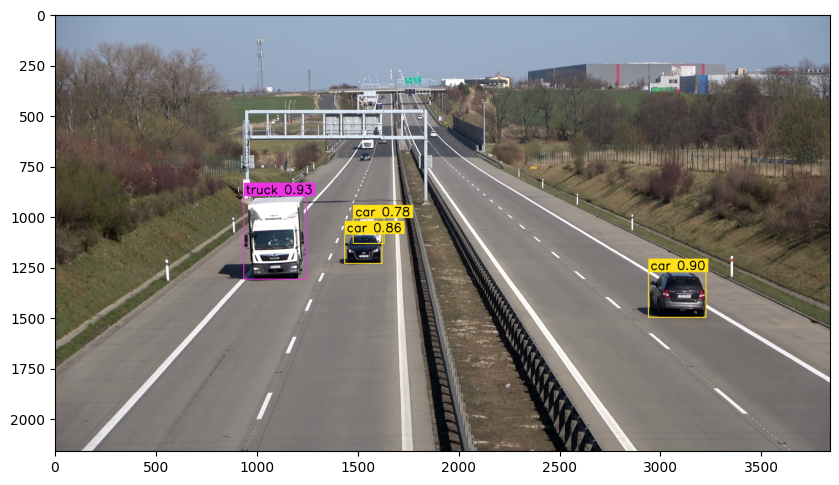

In [ ]:

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

iterator = iter(generator)
frame = next(iterator)

results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (10, 16))

## Predict and annotate whole video

In [ ]:

LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
from tqdm.notebook import tqdm



byte_tracker = BYTETracker(BYTETrackerArgs())

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

line_counter = LineCounter(start=LINE_START, end=LINE_END)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)


with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    for frame in tqdm(generator, total=video_info.total_frames):

        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]

        line_counter.update(detections=detections)

        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/538 [00:00<?, ?it/s]


0: 384x640 3 cars, 1 truck, 70.7ms
Speed: 5.6ms preprocess, 70.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 63.1ms
Speed: 11.1ms preprocess, 63.1ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 2 trucks, 69.3ms
Speed: 3.7ms preprocess, 69.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 63.3ms
Speed: 2.9ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 78.7ms
Speed: 10.3ms preprocess, 78.7ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 66.6ms
Speed: 3.2ms preprocess, 66.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 68.0ms
Speed: 3.2ms preprocess, 68.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 64.7ms
Speed: 10.1ms preprocess, 64.7